In [1]:
#### Basic DDQN code 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np 
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
import PIL.Image
from tensorflow.keras import backend as K
import cv2
import segmentation_models as sm
from IPython import display
import copy
from skimage.color import rgb2gray
import random
import gc
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import hausdorff_distance
import seg_metrics.seg_metrics as sg
import pandas as pd



2024-04-27 22:16:23.577109: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 22:16:24.093536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 22:16:24.093574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 22:16:24.186104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 22:16:24.371974: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2024-04-27 22:16:27.357470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 22:16:27.625103: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 22:16:27.625232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
s="BraTS20_Training_001flair_slice10.png"
s.split("flair")[0][-3:]

'001'

In [4]:
img_path=r'/home/bhavik/Desktop/Pratik/brats_dataset/images/brats2020flair/'
mask_path=r'/home/bhavik/Desktop/Pratik/brats_dataset/masks/brats2020mask/'

In [5]:
images=[]
masks=[]

In [6]:
def get_images(img_path=img_path,mask_path=mask_path,number=5000,threshold=0.1,patient_number_lower=00,patient_number_higher=300):
    #storing 5000 images and masks in the lists images and masks. Only storing those images in which masked region is greater than 1% 
    #and combining different mask calsses into one
    images=[]
    masks=[]
    grays=[]
    for root, dirs, files in os.walk(img_path,mask_path):
        print(len(files))
        for i,name in enumerate(files):
            image_path = img_path+name
            msk_path=mask_path+name.replace("flair","seg")
            if patient_number_lower<=int(image_path.split("flair")[1][-3:])<=patient_number_higher:
                try:
                    image = PIL.Image.open(image_path)
                    mask=PIL.Image.open(msk_path)
                    # Convert the mask to grayscale.
                    gray_mask = np.mean(mask.convert('RGB'), axis=2)
                    # Resize the mask to 240x240x1.
                    
                    resized_mask = np.resize(gray_mask, (240, 240,1))
                    val, counts = np.unique(resized_mask, return_counts=True)
                    if (1 - (counts[0]/counts.sum())) > threshold:
                        images.append(np.array(image.convert('RGB'))/255)
                        masks.append(np.array(resized_mask)/255)
                        grays.append(rgb2gray(np.array(image.convert('RGB'))/255))
                except:
                    continue
                if len(images)==number-1:
                    break
            else:
                continue
    images_array=np.array(images)
    masks_array=np.array(masks)
    bw_images_array=np.array(grays)
    unique_values=np.unique(masks_array[:100])
    masks_array[masks_array==unique_values[1]]=1
    masks_array[masks_array==unique_values[2]]=1

    del images,masks
    return images_array,masks_array,bw_images_array

In [7]:
images_array, masks_array,bw_images_array=get_images(img_path=img_path,mask_path=mask_path,number=1001,threshold=0.05,patient_number_lower=00,patient_number_higher=200)

57196


In [8]:
test_images_array, test_masks_array,test_bw_images_array=get_images(img_path=img_path,mask_path=mask_path,number=201,threshold=0.01,patient_number_lower=201,patient_number_higher=350)

57196


In [9]:
images_array.shape

(1000, 240, 240, 3)

In [10]:
test_images_array.shape

(200, 240, 240, 3)

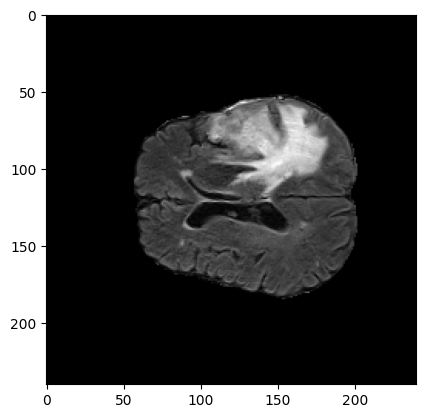

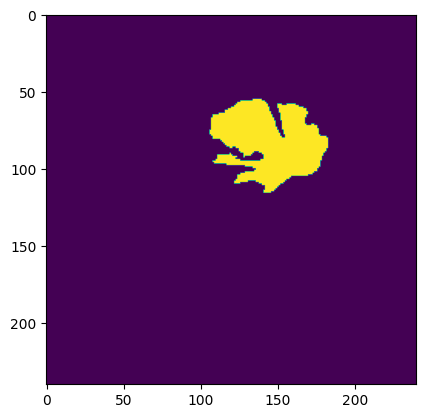

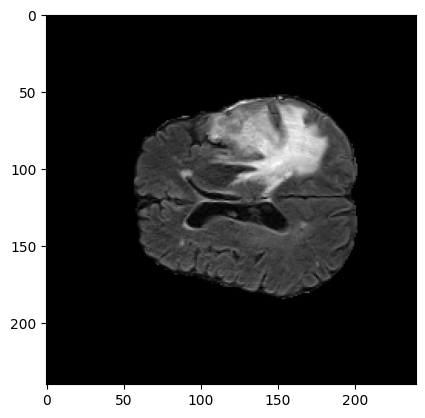

In [11]:
plt.imshow(images_array[0])
plt.show()
plt.imshow(masks_array[0])
plt.show()
plt.imshow(bw_images_array[0],cmap='gray')

In [12]:
val, counts = np.unique(masks_array[0], return_counts=True)
print(val)
print(counts)

[0. 1.]
[54704  2896]


In [13]:
#converting mask class to one hot encoded vector- why ?
from keras.utils import to_categorical
masks_cat = to_categorical(masks_array, num_classes=2)
test_masks_cat = to_categorical(test_masks_array, num_classes=2)

print(masks_cat.shape)
print(test_masks_cat.shape)

(1000, 240, 240, 2)
(200, 240, 240, 2)


In [14]:
X_train=images_array
y_train=masks_cat
bw_train=bw_images_array
X_test=test_images_array
y_test=test_masks_cat
bw_test=test_bw_images_array

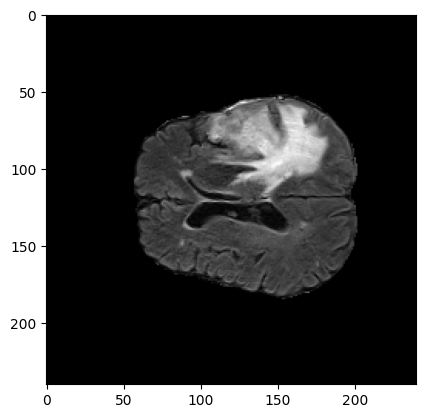

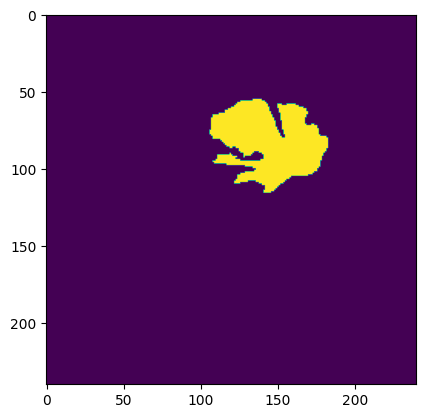

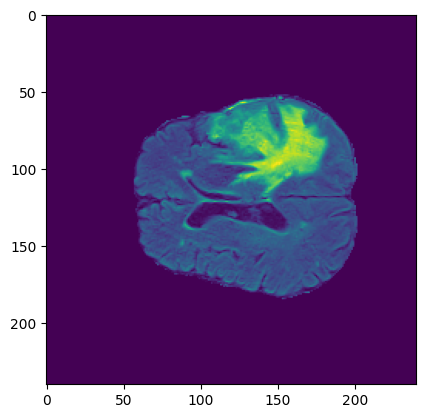

In [15]:
plt.imshow(X_train[0])
plt.show()
plt.imshow(masks_array[0])
plt.show()
plt.imshow(bw_train[0])
plt.show()

In [16]:
IMG_HEIGHT = images_array.shape[1]
IMG_WIDTH  = images_array.shape[2]
IMG_CHANNELS = images_array.shape[3]
print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

240
240
3


# RL Model

In [17]:
GAMMA = 0.99
LEARNING_RATE = 0.5e-7

MEMORY_SIZE = 1000
BATCH_SIZE = 128

#exploration is epsilon
EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.99

In [18]:
state_space=10 #10 dimensional state space
action_space=3 #3 action [-0.1,0,0.1]
all_actions=[-0.1,0,0.1]
# intermediate_dim=16

In [19]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,state_space)))
        model.add(Dense(512,activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        model.compile(optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=self.lr), loss = "mse", metrics = ['accuracy'])
        return model

In [20]:
class DQNSolver:
    def __init__(self,state_space,action_space, decay_coe = 0.99, 
                  memory_size = MEMORY_SIZE,EXPLORATION_DECAY=EXPLORATION_DECAY,LEARNING_RATE=LEARNING_RATE,EPSILON_MAX=EPSILON_MAX,EPSILON_MIN=EPSILON_MIN,BATCH_SIZE=BATCH_SIZE):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel((1,self.states), self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
    #INPUT to deep model     
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=EXPLORATION_DECAY
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
        
    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
            s =np.array( [row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)
            s_ =np.array( [row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
                                 
            loss = self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            
            

In [21]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


2024-04-27 22:17:21.956597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 22:17:21.956740: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 22:17:21.956793: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [22]:

#step function for new state - 
def step(state,action,ground_truth):
    #step function to get new state and reward based on action taken and current state
    # new_state=[]
    all_actions=[-0.1,0,0.1]
    new_state=list(copy.deepcopy(state))
    # print(action)
    # print(all_actions[action])
    # print("before ",new_state)
    new_state[9]=(max(min(new_state[9]+all_actions[action],1),0))
    # print("after ",new_state)
    # if (new_state[9]==ground_truth) :
    #     reward=1
    # else:
    #     reward=-(ground_truth-new_state[9])**2
    if ((ground_truth-state[9])**2-(ground_truth-new_state[9])**2) >0.001:
        reward=0.1
    elif (((ground_truth-state[9])**2-(ground_truth-new_state[9])**2)<=0.001)and(((ground_truth-state[9])**2-(ground_truth-new_state[9])**2)>=-0.001):
        reward=0
    else:
        reward=-0.1
    # reward=(ground_truth-state[4])**2-(ground_truth-new_state[4])**2 
    #reward function based on if the action taken changes probability of the class 1 towards the ground truth or not
    return [new_state,reward]
    

In [23]:
#function to get state from image pixel
def get_state(i,j,predicted_prob,bw_image):
    height=len(bw_image)
    width=len(bw_image[0])
    state=[]
    if i>0 and i< height-1:
        if j>0 and j<width-1:
            state.extend(bw_image[i-1,j-1:j+2].reshape(3,))
            state.extend(bw_image[i,j-1:j+2].reshape(3,))
            state.extend(bw_image[i+1,j-1:j+2].reshape(3,))
        elif j==0:
            state.extend([0])
            state.extend(bw_image[i-1,j:j+2].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i,j:j+2].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i+1,j:j+2].reshape(2,))
        else:
            state.extend(bw_image[i-1,j-1:j+1].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i,j-1:j+1].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i+1,j-1:j+1].reshape(2,))
            state.extend([0])
    else:
        if i==0:
            if j>0 and j<width-1:
                state.extend([0,0,0])
                state.extend(bw_image[i,j-1:j+2].reshape(3,))
                state.extend(bw_image[i+1,j-1:j+2].reshape(3,))
            elif j==0:
                state.extend([0,0,0])
                state.extend([0])
                state.extend(bw_image[i,j:j+2].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i+1,j:j+2].reshape(2,))
            else:
                state.extend([0,0,0])
                state.extend(bw_image[i,j-1:j+1].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i+1,j-1:j+1].reshape(2,))
                state.extend([0])
        else:
            if j>0 and j<width-1:
                state.extend(bw_image[i-1,j-1:j+2].reshape(3,))
                state.extend(bw_image[i,j-1:j+2].reshape(3,))
                state.extend([0,0,0])
            elif j==0:
                state.extend([0])
                state.extend(bw_image[i-1,j:j+2].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i,j:j+2].reshape(2,))
                state.extend([0,0,0])
            else:
                state.extend(bw_image[i-1,j-1:j+1].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i,j-1:j+1].reshape(2,))
                state.extend([0])
                state.extend([0,0,0])
    # state.append(predicted_img[i][j])
    # scaled_state=list(MinMaxScale(state))
    state.append(predicted_prob[i][j])
    return np.array(state).reshape(10,)


        



# HELPER FUNCTIONS

In [24]:
def get_bounding_box(img):
#get bounding box accros tumor segmentation
    left=240
    top=0
    right=0
    bottom=0
    top_flag=0
    
    for i in range(len(img)):
        forward=list(img[i])
        reverse=list(img[i])
        reverse.reverse()
        if (np.max(img[i])!=0 and top_flag==0):
            top=i
            top_flag=1
        if np.max(img[i])!=0:
            bottom=i
            for k in range(len(forward)):
                if forward[k]!=0:
                    if k<left:
                        left=k 
                    break
            for k in range(len(reverse)):
                if reverse[k]!=0:
                    if len(reverse)-k-1>right:
                        right=len(reverse)-k-1
                    break
            
        
    del forward
    del reverse
    return left, top, right, bottom

In [25]:
def cropping(indices,predicted_probs_images,X_images=X_train,y_images=y_train,bw_images=bw_train,cushion=0):
    #to get cropped images, masks and predictions based on segmentation by Unet
    cropped_images=[]
    cropped_masks=[]
    cropped_predictions=[]
    cropped_predicted_imgs=[]
    predicted_imgs=[]
    cropped_bw_images=[]
    for i in indices:
        cushion=cushion
        left=240
        top=0
        right=0
        bottom=0
        # prediction = (unet_model.predict(np.expand_dims(X_images[i],0),verbose=0))
        # predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        # predicted_imgs.append(predicted_img)
        left, top, right, bottom=get_bounding_box(bw_images[i])
        left=max(left-cushion,0)
        right=min(right+cushion,IMG_WIDTH)
        top=max(0,top-cushion)
        bottom=min(bottom+cushion,IMG_HEIGHT)
        cropped_prediction=predicted_probs_images[i][top:bottom,left:right]
        cropped_predictions.append(cropped_prediction)
        cropped_bw_image=bw_images[i][top:bottom,left:right]
        cropped_bw_images.append(cropped_bw_image)
        # cropped_predicted_img=predicted_img[top:bottom,left:right]
        cropped_image=X_images[i][top:bottom,left:right]
        cropped_mask=np.argmax(y_images[i], axis=-1)[top:bottom,left:right]
        cropped_images.append(cropped_image)
        cropped_masks.append(cropped_mask)
        # cropped_predicted_imgs.append(cropped_predicted_img)
        # display.clear_output(wait=True)
    return cropped_images,cropped_masks,cropped_predictions,cropped_bw_images

# Final Training Loop

In [26]:
# training images
DQN_TRAINING_SAMPLE_SIZE=500
CUSHION=0

In [27]:
predicted_probs_images=np.zeros((len(X_train),IMG_HEIGHT,IMG_WIDTH))
# predicted_probs_images=np.random.randint(10,size=(len(X_train),IMG_HEIGHT,IMG_WIDTH))/10
predicted_probs_images.shape

(1000, 240, 240)

In [29]:
#use this
def dqn_training_loop(rewards_array,cropped_images,cropped_predictions,cropped_masks,cropped_bw_images,all_actions):
    action_images=[]
    reward_array_per_img=[]
    reward_sum=0
    for n in range(len(cropped_images)):
        print(reward_sum)
        reward_sum=0
        x=np.array(dqn_solver.model.Qpolicy.weights[0][0])
        if math.isnan(x[0]):
            print("NaN Encountered")
            break
        # print(f"image {n}")
        print(f"image:{n}")
        action_image=[]
        for i in range(len(cropped_images[n])):
            actions_temp=[]
            for j in range(len(cropped_images[n][i])):
                state=get_state(i,j,cropped_predictions[n],cropped_bw_images[n])
                action=dqn_solver.act(state)

                actions_temp.append(all_actions[action])
                new_state,reward=step(state,action,cropped_masks[n][i][j])

                reward_sum+=reward
                cropped_predictions[n][i][j]=new_state[-1]
                # t
                if np.random.random()<0.4:                    
                    #non tumore region
                    dqn_solver.remember(state,action,reward,np.array(new_state),False)
                else:
                    #tumore region
                    if cropped_masks[n][i][j]>0.5:
                     
                        dqn_solver.remember(state,action,reward,np.array(new_state),False)
            # if i%2==0:
            dqn_solver.train()
                

            action_image.append(actions_temp)
        dqn_solver.decrement_epsilon()
        dqn_solver.update_target_model()
        # action_images.append(action_image)
        # dqn_solver.forget()
        
        display.clear_output(wait=True)
        reward_array_per_img.append(reward_sum)
    rewards_array.append(reward_array_per_img)
    # return action_images,reward_array_per_img
    
    

In [25]:
rewards_array=[]
all_indices=[]

In [ ]:
#main loop
#500 images - it will run once
for t in range(1):
    # it takes random images from all training data, here we are taking all 500 once, we can do out of 1000, any 20
    indices=random.sample([u for u in range(len(X_train))], DQN_TRAINING_SAMPLE_SIZE)
    all_indices.append(indices)
    cropped_images,cropped_masks,cropped_predictions,cropped_bw_images=cropping(indices,predicted_probs_images,X_train,y_train,bw_train,cushion=CUSHION)
    # number of loop after n images
    for _ in range(3):
        dqn_solver.epsilon=1
        # dqn_training_with_loop(rewards_array,cropped_images,cropped_predictions,cropped_masks,cropped_bw_images,all_actions,loops=1)
        dqn_training_loop(rewards_array=rewards_array,cropped_images=cropped_images,cropped_predictions=cropped_predictions,cropped_masks=cropped_masks,cropped_bw_images=cropped_bw_images,all_actions=all_actions)
        # plt.plot(rewards_array[2*t])
        # plt.savefig('rewards_1.jpg')
    # plt.plot(rewards_array[2*t+1])
    # plt.savefig('rewards_2.jpg')


In [60]:
# plt.plot(rewards_array[0])

IndexError: list index out of range

In [ ]:
# dqn_solver.model.Qpolicy.save_weights('RL_model_weights_500_3_0_4')

# Inference

In [264]:
#for loading model
#if loading model run all the code before final training loop, and then run the code from here
dqn_solver.model.Qpolicy.load_weights('RL_model_weights_500_3_0_4')
dqn_solver.model.Qtarget.load_weights('RL_model_weights_500_3_0_4')
dqn_solver.epsilon=0.01

In [265]:
def dqn_inference_loop(cropped_images,cropped_predictions,cropped_masks,all_actions,cropped_bw_images,loops=5):
    dqn_solver.epsilon=0.01
    action_images=[]
    reward_sum=0
    for m in range(loops):
        for n in range(len(cropped_images)):
            x=np.array(dqn_solver.model.Qpolicy.weights[0][0])
            if math.isnan(x[0]):
                print("NaN Encountered")
                break
            action_image=[]
            for i in range(len(cropped_images[n])):
                actions_temp=[]
                for j in range(len(cropped_images[n][i])):
                    state=get_state(i,j,cropped_predictions[n],cropped_bw_images[n])
                    action=dqn_solver.act(state.reshape(1,10))
                    actions_temp.append(all_actions[action])
                    new_state,reward=step(state,action,cropped_masks[n][i][j])
                    reward_sum+=reward
                    # dqn_solver.remember(state,action,reward,np.array(new_state),False)
                    # if(abs(reward)>0.01):
                    #     print(reward)
                    cropped_predictions[n][i][j]=max(min(cropped_predictions[n][i][j]+all_actions[action],1),0)
                    # cropped_predictions[n][i][j][0]=max(min(cropped_predictions[n][i][j][0]-all_actions[action],1),0)
                action_image.append(actions_temp)
            if m==0:
                action_images.append(action_image)
            else:
                action_images[n]=np.add(action_images[n],action_image)
            display.clear_output(wait=True)
        print(reward_sum)
    return action_images

    
    

In [266]:
predicted_probs_images_test=np.zeros((len(X_test),IMG_HEIGHT,IMG_WIDTH))
predicted_probs_images_test.shape

(200, 240, 240)

In [41]:
cropping_indices=[i for i in range(50)]
# cropping_indices=[3]

In [42]:
#gives infernce output
cropped_images,cropped_masks,cropped_predictions,cropped_bw_images=cropping(cropping_indices,predicted_probs_images_test,X_test,y_test,bw_test,cushion=CUSHION)
    
action_images=dqn_inference_loop(cropped_images,cropped_predictions,cropped_masks,all_actions,cropped_bw_images,loops=10)

# prediction=complete_model([np.expand_dims(X_test[2],0),action_images_final])
# predicted_img_test=np.argmax(prediction, axis=-1)
# plt.imshow(predicted_img_test[0])
# plt.show()

-45049.99999962493


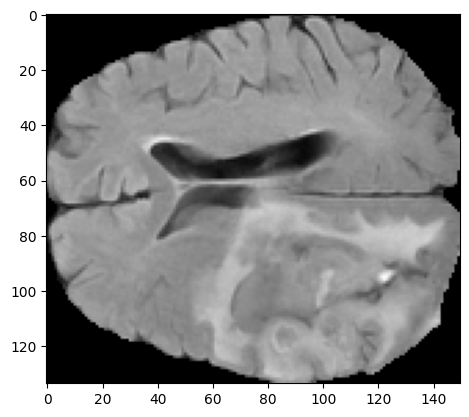

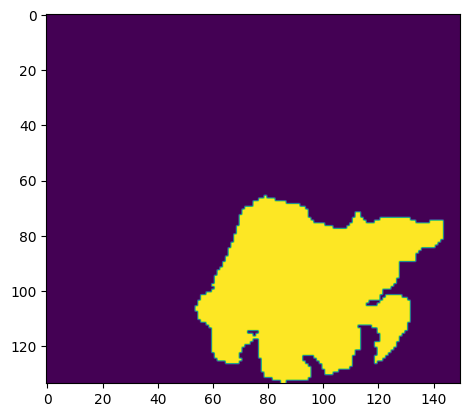

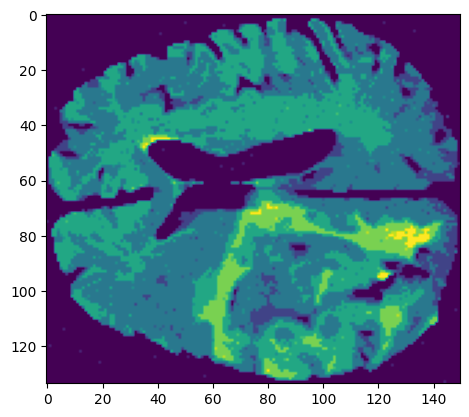

In [346]:
plt.imshow(cropped_images[1])
plt.show()
plt.imshow(cropped_masks[1])
plt.show()
plt.imshow(cropped_predictions[1])
plt.show()


In [143]:
cropped_predictions[0].shape

(131, 107)

(array([ 173.,  225.,  258.,  230.,  227.,  263.,  267.,  280.,  332.,
         403.,  613., 1101., 1863., 2151., 1769.,  818.,  321.,  197.,
          85.,   25.]),
 array([0.04313725, 0.09098039, 0.13882353, 0.18666667, 0.2345098 ,
        0.28235294, 0.33019608, 0.37803922, 0.42588235, 0.47372549,
        0.52156863, 0.56941176, 0.6172549 , 0.66509804, 0.71294118,
        0.76078431, 0.80862745, 0.85647059, 0.90431373, 0.95215686,
        1.        ]),
 <BarContainer object of 20 artists>)

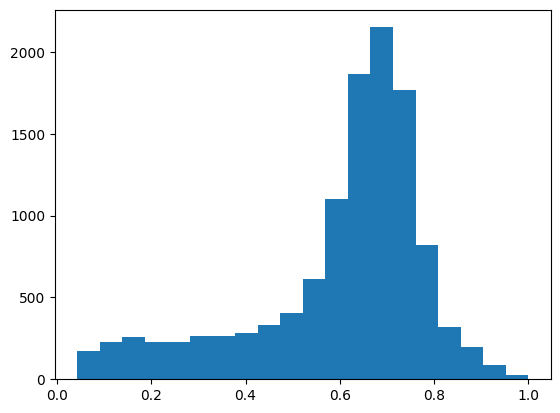

In [148]:
# plt.hist(np.array([x for x in cropped_bw_images[11].reshape(136*122,) if x!=0]),bins=20)

(array([ 180.,  154.,  128.,  135.,  124.,  130.,  180.,  574., 2113.,
        1924., 1176.,  515.,  270.,  221.,  271.,  599.,  937.,  942.,
         706.,  147.]),
 array([0.00392157, 0.05372549, 0.10352941, 0.15333333, 0.20313725,
        0.25294118, 0.3027451 , 0.35254902, 0.40235294, 0.45215686,
        0.50196078, 0.55176471, 0.60156863, 0.65137255, 0.70117647,
        0.75098039, 0.80078431, 0.85058824, 0.90039216, 0.95019608,
        1.        ]),
 <BarContainer object of 20 artists>)

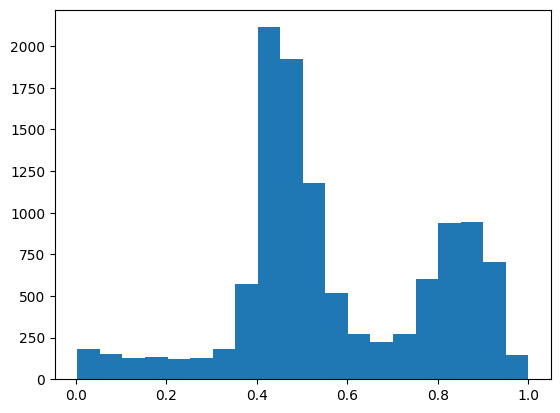

In [144]:
# plt.hist(np.array([x for x in cropped_bw_images[0].reshape(131*107,) if x!=0]),bins=20)

In [155]:
# np.percentile(np.array([x for x in cropped_bw_images[11].reshape(136*122,) if x!=0]),90)

0.7725490196078432

In [147]:
# np.median(np.array([x for x in cropped_bw_images[11].reshape(136*122,) if x!=0]))

0.6549019607843137

In [44]:
# plt.hist(cropped_predictions[0].reshape(125*163,),bins=40)

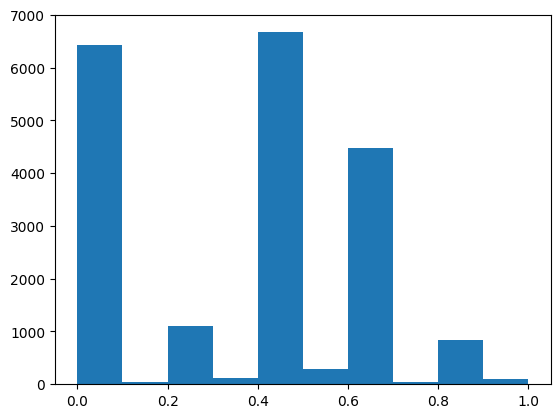

In [347]:
k=1
(n, bins, patches) =plt.hist(cropped_predictions[k].reshape(cropped_predictions[k].shape[0]*cropped_predictions[k].shape[1],))

In [363]:
np.percentile(cropped_predictions[k].reshape(cropped_predictions[k].shape[0]*cropped_predictions[k].shape[1],),99)

0.7999999999999999

In [233]:
# len(n)

10

In [353]:
n

array([6419.,   36., 1109.,  118., 6669.,  293., 4470.,   52.,  843.,
         91.])

In [400]:
def get_predicted_mask(cropped_predictions,k):
    predcited_mask=[]
    # mean=np.mean([x for x in cropped_bw_images[k].reshape(cropped_bw_images[k].shape[0]*cropped_bw_images[k].shape[1],) if x!=0.0])
    # percentiles=[60,70,80,90,95]
    threshold=0
    (n, bins, patches) =plt.hist(cropped_predictions[k].reshape(cropped_predictions[k].shape[0]*cropped_predictions[k].shape[1],))
    display.clear_output(wait=False)
    for i in range(len(n)-1,1,-1):
        if n[i]>n[i-1]*8:
            if i/10.0<=np.percentile(cropped_predictions[k].reshape(cropped_predictions[k].shape[0]*cropped_predictions[k].shape[1],),90)+0.0001:
                threshold=i/10.0
                break
    if threshold==0:
        if n[i]>n[i-1]*8:
            threshold=i/10.0
    print(threshold)
    # threshold=np.percentile(cropped_predictions[k].reshape(cropped_predictions[k].shape[0]*cropped_predictions[k].shape[1],),80)
    # for percentile in percentiles:
    #     if np.percentile(cropped_predictions[k].reshape(cropped_predictions[k].shape[0]*cropped_predictions[k].shape[1],),percentile)>mean:
    #         threshold=np.percentile(cropped_predictions[k].reshape(cropped_predictions[k].shape[0]*cropped_predictions[k].shape[1],),percentile)
    #         break
    for i in range(len(cropped_predictions[k])):
        temp=[]
        for j in cropped_predictions[k][i]:
            if j>=threshold:
                temp.append(1)
            else:
                temp.append(0)
        predcited_mask.append(temp)
    return predcited_mask

0.6


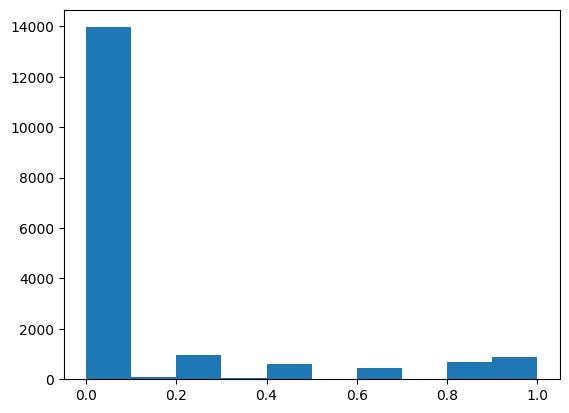

In [410]:
predcited_mask=get_predicted_mask(cropped_predictions,4)

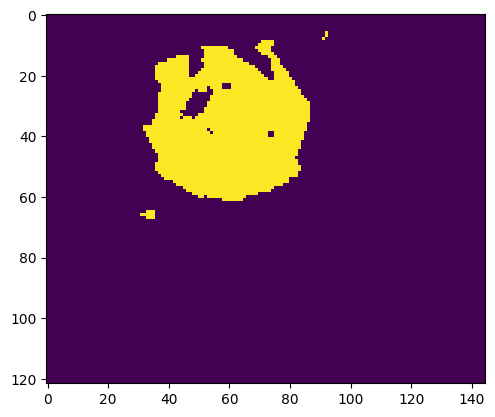

In [411]:
plt.imshow(predcited_mask)

0.4


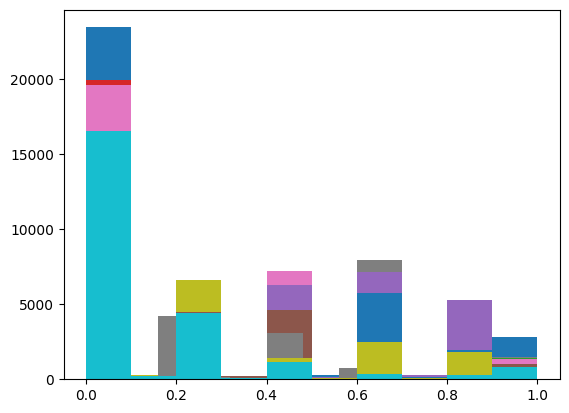

In [412]:
predicted_masks=[]
for i in range(len(cropped_predictions)):
    predcited_mask=get_predicted_mask(cropped_predictions,i)
    predicted_masks.append(predcited_mask)


In [413]:
def get_final_predictions(cropping_indices,cropped_predictions,bw_images,cushion):
    n_imgs=len(cropped_predictions)
    cropped_predictions_final=np.zeros((n_imgs,240,240,1))
    k=0
    for n in cropping_indices:
        left, top, right, bottom=get_bounding_box(bw_images[n])
        left=max(left-cushion,0)
        right=min(right+cushion,IMG_WIDTH)
        top=max(0,top-cushion)
        bottom=min(bottom+cushion,IMG_HEIGHT)
        cropped_predictions_final[k][top:bottom,left:right,0]=np.add(cropped_predictions_final[k][top:bottom,left:right,0],cropped_predictions[k])
        k+=1
    return cropped_predictions_final


In [414]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice 

In [415]:
dice_scores=[]
hd95_scores=[]
precision_scores=[]
recall_scores=[]

In [416]:
cropped_predictions_final=get_final_predictions(cropping_indices,predicted_masks,bw_test,CUSHION)
for i in range(len(cropped_predictions_final)):
    print(i)
    metrics = sg.write_metrics(labels=[1],
                  gdth_img=test_masks_array[cropping_indices[i]].reshape(240,240),
                  pred_img=np.array(cropped_predictions_final[i].reshape(240,240)),
                  metrics=['dice', 'hd95','precision','recall'])
    dice_scores.append(metrics[0]['dice'][0])
    hd95_scores.append(metrics[0]['hd95'][0])
    precision_scores.append(metrics[0]['precision'][0])
    recall_scores.append(metrics[0]['recall'][0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [417]:
cropped_predictions_final[0].shape

(240, 240, 1)

In [418]:
dice_scores

[0.8320427587786243,
 0.5007074669960305,
 0.9325892764785503,
 0.4713678043555133,
 0.8625610776558539,
 0.4715944757315874,
 0.7364275307858411,
 0.5570116738725046,
 0.6945176744032188,
 0.514788880892509,
 0.6424380759448558,
 0.6479094470181295,
 0.5700796768047651,
 0.9627775103395804,
 0.14736552564189875,
 0.7998631345303137,
 0.4425425167833027,
 0.0956777669157121,
 0.7832041716491703,
 0.5961240860891768,
 0.376738210685661,
 0.4994508017898524,
 0.5405985766985881,
 0.7272723494689094,
 0.5515884207047426,
 0.7925845254453888,
 0.4472048426863798,
 0.8431862946390561,
 0.8998586389779129,
 0.7802600588607761,
 0.40044925576393486,
 0.519578509326474,
 0.7887321721881204,
 0.24585235406751946,
 0.32361074651676675,
 0.8362813631386219,
 0.544044433476947,
 0.18899672297805328,
 0.6876678579176085,
 0.5373217842388078,
 0.3838256970993166,
 0.12314339059446985,
 0.44713366302894625,
 0.7217895322035348,
 0.6811619438768602,
 0.8334751206398806,
 0.879506997733829,
 0.17887580

In [419]:
df=pd.DataFrame({'dice':dice_scores,'hd95':hd95_scores,'recall':recall_scores,'precision':precision_scores})
df.to_csv('RL_model_metric_scores_500_3_0_4.csv')

(array([2., 3., 1., 1., 0., 1., 2., 1., 5., 4., 6., 1., 2., 3., 3., 3., 4.,
        4., 2., 2.]),
 array([0.09567777, 0.13903275, 0.18238774, 0.22574273, 0.26909772,
        0.3124527 , 0.35580769, 0.39916268, 0.44251766, 0.48587265,
        0.52922764, 0.57258263, 0.61593761, 0.6592926 , 0.70264759,
        0.74600257, 0.78935756, 0.83271255, 0.87606754, 0.91942252,
        0.96277751]),
 <BarContainer object of 20 artists>)

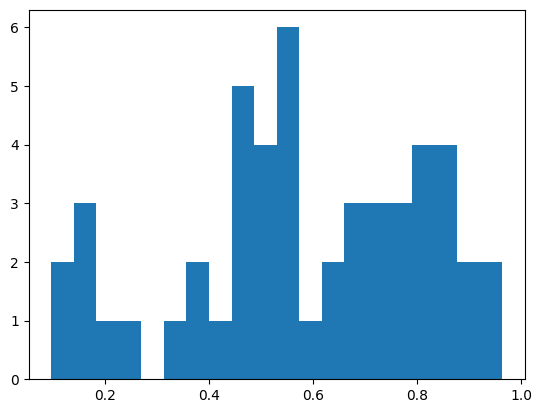

In [420]:
plt.hist(dice_scores,bins=20)

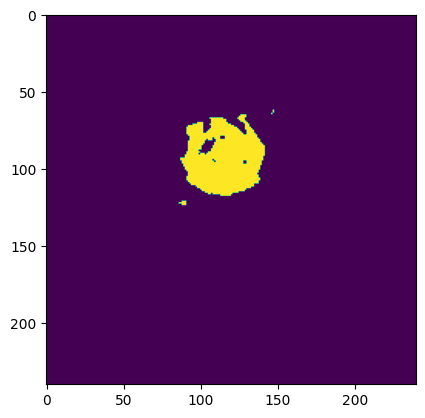

In [421]:
plt.imshow(cropped_predictions_final[4])